In [34]:
import os
from torch.utils.data import Dataset
from PIL import Image 
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# read img as RGB ndarray and easier to interact with pytorch/tensorflow with PIL/Numpy ndarray
# opencv cv2.imread read img as BGR int8 which needs conversion not directly used for pytorch and tensorflow

In [35]:
dict = {0:'ants',1:'bees'}
print(dict[0])
print(dict[1])

ants
bees


In [36]:
train_ants_dir = '/mnt/d/dataset/train/ants/'
train_bees_dir = '/mnt/d/dataset/train/bees/'
val_ants_dir = '/mnt/d/dataset/val/ants/'
val_bees_dir = '/mnt/d/dataset/val/bees/'
train_ants_name_list = os.listdir(train_ants_dir)
train_bees_name_list = os.listdir(train_bees_dir)
print(len(train_ants_name_list))
print(len(train_bees_name_list))
print(train_ants_name_list[0:3])
print(train_bees_name_list[0:3])
print(os.path.join(train_bees_dir,train_bees_name_list[0]))

123
121
['0013035.jpg', '1030023514_aad5c608f9.jpg', '1095476100_3906d8afde.jpg']
['1092977343_cb42b38d62.jpg', '1093831624_fb5fbe2308.jpg', '1097045929_1753d1c765.jpg']
/mnt/d/dataset/train/bees/1092977343_cb42b38d62.jpg


In [37]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(150,150)),
    torchvision.transforms.RandomCrop(size=150,padding=4),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(), 
    torchvision.transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
])

In [38]:
class MyDataset(Dataset):
    def __init__(self,dir):
        super().__init__()
        self.dir = dir
        self.img_list_name = os.listdir(dir)
    def __getitem__(self, idx):
        img_path = self.dir + self.img_list_name[idx]
        # print(img_path)
        img = Image.open(img_path)
        img = transform(img)
        # print(img.shape)
        label = self.dir[-5:-1]
        # print(label)
        if label == 'ants':
            label = torch.tensor(0)
        elif label == 'bees':
            label = torch.tensor(1)
        # print(label)
        return img, label    
    def __len__(self):
        return len(self.img_list_name)
           
# myds = MyDataset(train_ants_dir)
# myds.__getitem__(0)
# print(myds.__len__())
# myds.dir+myds.img_list_name[0]

In [39]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 150, 75, 37, 18, 9, 9*9*256
        self.b1 = nn.Sequential
        (
            nn.Conv2d(3,32,3,1),# in_ch, out_ch, ker_size, padding
            nn.ReLU(),
            nn.MaxPool2d(2,2),# ker_size, stride
            nn.BatchNorm2d(32)
        )
        self.b2 = nn.Sequential(
            nn.Conv2d(32,64,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(64)
        )
        self.b3 = nn.Sequential(
            nn.Conv2d(64,128,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(128)
        )
        self.b4 = nn.Sequential(
            nn.Conv2d(128,256,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(256)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(9*9*256,1024),
            nn.ReLU(inplace=True),# save memory
            
            nn.Linear(1024,256),
            nn.ReLU(inplace=True),# save memory
            
            nn.Linear(256,32),
            nn.Linear(32,2),
        )
    def forward(self,x):
        out = self.b1(x)
        out = self.b2(out)
        out = self.b3(out)
        out = self.b4(out)
        return self.fc(out)
        

In [40]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(device)
net = MyNet()
net.to(device)
print(net)

cpu
MyNet(
  (b2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (b3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (b4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=20736, out_features=1024, bias=True)
    (2): ReLU(inplace=True)
    (3): Line

In [41]:
train_ants_ds = MyDataset(train_ants_dir)
train_bees_ds = MyDataset(train_bees_dir)
train_ds = train_ants_ds + train_bees_ds

val_ants_ds = MyDataset(val_ants_dir)
val_bees_ds = MyDataset(val_bees_dir)
val_ds = val_ants_ds + val_bees_ds

train_loader = DataLoader(dataset = train_ds,batch_size = 8, shuffle = True, drop_last = True)
val_loader =   DataLoader(dataset = val_ds,  batch_size = 8, shuffle = True, drop_last = True)

print(len(train_ants_ds)+len(train_bees_ds))
print(len(val_ants_ds)+len(val_bees_ds))
print(len(train_ds))
print(len(val_ds))

244
153
244
153


In [42]:
loss = nn.CrossEntropyLoss()
loss = loss.to(device)

In [43]:
optim = torch.optim.Adam(net.parameters(),lr=0.0001)

In [44]:
net.train()
for imgs, labels in train_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)
    # print(imgs.shape)
    # print(labels.shape)
    # print(labels)
    
    out = net(imgs)
    print(out)

TypeError: torch.FloatTensor is not a Module subclass

训练集长度为244
测试集长度为153
----------第1次训练开始----------
训练次数10次，loss=0.8474231958389282
训练次数20次，loss=0.5806494951248169
训练次数30次，loss=0.6852123737335205
第1轮训练结束，准确率0.5882353186607361
----------第2次训练开始----------
训练次数40次，loss=0.3664427399635315
训练次数50次，loss=0.6231899857521057
训练次数60次，loss=0.5788557529449463
第2轮训练结束，准确率0.6470588445663452
----------第3次训练开始----------
训练次数70次，loss=0.5873002409934998
训练次数80次，loss=0.4566968083381653
训练次数90次，loss=0.6562461256980896
第3轮训练结束，准确率0.5490196347236633
----------第4次训练开始----------
训练次数100次，loss=0.8480017185211182
训练次数110次，loss=0.48914027214050293
训练次数120次，loss=0.31687742471694946
第4轮训练结束，准确率0.6274510025978088
----------第5次训练开始----------
训练次数130次，loss=0.9176957011222839
训练次数140次，loss=0.5388323068618774
训练次数150次，loss=0.4958060383796692
第5轮训练结束，准确率0.6797385811805725


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

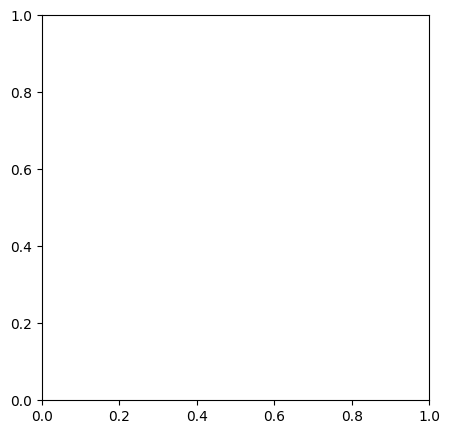

In [3]:
import os
from matplotlib import pyplot as plt
from matplotlib import font_manager
import torch
import torchvision
from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader

font = font_manager.FontProperties(fname='C:\Windows\Fonts\simhei.ttf')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



train_root_dir = '/mnt/d/dataset/train'
train_ants_dir = 'ants'
train_bees_dir = 'bees'

test_root_dir = '/mnt/d/dataset/val'
test_ants_dir = 'ants'
test_bees_dir = 'bees'

tran_pose = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(32,32)),
    torchvision.transforms.RandomCrop(size=32,padding=4),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
])

def plot(train_loss):
    plt.figure(figsize=(5,5))
    plt.plot(train_loss,label='train_loss',alpha = 0.5)
    plt.title('蚂蚁蜜蜂数据集的训练与识别',fontproperties=font)
    plt.xlabel('训练次数',fontproperties=font)
    plt.ylabel('损失',fontproperties=font)
    plt.legend()
    plt.show()

class MyDataset(Dataset):
    def __init__(self,root_dir,label_dir):
        super().__init__()
        self.root_dir = root_dir
        self.label_dir = label_dir
        self.path = os.path.join(self.root_dir,self.label_dir)
        self.img_path = os.listdir(self.path)

    def __getitem__(self,idx):
        img_name = self.img_path[idx]
        img_item_path = os.path.join(self.root_dir,self.label_dir,img_name)
        img = Image.open(img_item_path)
        img = tran_pose(img)
        label = self.label_dir
        if label == 'ants':
            label = torch.tensor(0)
        else:
            label = torch.tensor(1)
        return img,label

    def __len__(self):
        return len(self.img_path)

class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.BatchNorm2d(num_features=32),

            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.BatchNorm2d(num_features=64),

            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.BatchNorm2d(128),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),

            nn.Linear(128*4*4,1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(1024,256),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(256,32),
            nn.Linear(32,2)
        )

    def forward(self,x):
        return self.fc(self.main(x))

mydataset = MyDataset(train_root_dir,train_ants_dir)

mynet = MyNet()
mynet = mynet.to(device)

train_ants_dataset = MyDataset(train_root_dir,train_ants_dir)
train_bees_dataset = MyDataset(train_root_dir,train_bees_dir)
train_datasets = train_ants_dataset + train_bees_dataset

test_ants_dataset = MyDataset(test_root_dir,test_ants_dir)
test_bees_dataset = MyDataset(test_root_dir,test_bees_dir)
test_datasets = test_ants_dataset + test_bees_dataset

train_data_load = DataLoader(dataset=train_datasets,batch_size=8,shuffle=True,drop_last=True)
test_data_load = DataLoader(dataset=test_datasets,batch_size=8,shuffle=True,drop_last=True)

train_data_size = len(train_datasets)
test_data_size = len(test_datasets)

print(f'训练集长度为{train_data_size}')
print(f'测试集长度为{test_data_size}')

loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)
train_loss = list()

learning_rate = 1e-3
optim = torch.optim.Adam(mynet.parameters(),learning_rate)

train_step = 0

epoch = 5

if __name__ == '__main__':
    for i in range(epoch):
        print(f'----------第{i+1}次训练开始----------')
        mynet.train()
        for data in train_data_load:
            imgs , targets = data
            imgs = imgs.to(device)
            targets = targets.to(device)

            outputs = mynet(imgs)
            loss = loss_fn(outputs,targets)
            optim.zero_grad()
            loss.backward()
            optim.step()

            train_step += 1
            if train_step % 10 == 0:
                train_loss.append(loss)
                print(f'训练次数{train_step}次，loss={loss}')

        mynet.eval()
        accuracy = 0
        accuracy_total = 0
        with torch.no_grad():
            for data in test_data_load:
                imgs,targets = data
                imgs = imgs.to('cuda')
                targets = targets.to('cuda')

                outputs = mynet(imgs)
                accuracy = (outputs.argmax(axis=1) == targets).sum()
                accuracy_total += accuracy

            print(f'第{i+1}轮训练结束，准确率{accuracy_total/test_data_size}')
            torch.save(mynet,f'ants_bees_{i+1}_acc_{accuracy_total/test_data_size}')

    plot(train_loss)



